In [68]:
import json
import datetime
import altair as alt
import pandas as pd
import numpy as np
import os
hits = [
'2018-08-10_00-00-00', #0
'2018-08-29_11_32_44',
'2018-08-29_22-54-16', #2
'2018-09-05_21-38-43',
'2018-09-07_11-34-48'
]
base = 'hits/' + hits[2]
def cd(file):
    return os.path.join(base, file)

In [69]:
def duration_plot(assignments):
    times = []
    submit_times = []
    for l in assignments:
        submit = datetime.datetime.strptime(l['SubmitTime'][:-6], "%Y-%m-%d %H:%M:%S")
        accept = datetime.datetime.strptime(l['AcceptTime'][:-6], "%Y-%m-%d %H:%M:%S")
        submit_times.append(submit)
        diff = (submit - accept).total_seconds()/60.0
        times.append({"diff": diff})
    spec = {
      "data": {"values": times},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "diff",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
    print('min - max: ', min(submit_times), max(submit_times))
    print('mean duration: ', np.mean(list(map(lambda d: d['diff'], times))))
    return alt.VegaLite(spec)

min - max:  2018-08-29 22:57:48 2018-08-30 21:20:15
mean duration:  8.14783333333


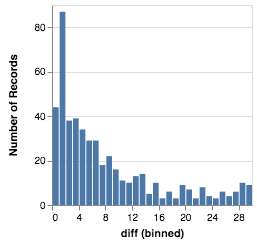

min - max:  2018-08-30 23:02:32 2018-08-31 01:54:16
mean duration:  6.55426666667


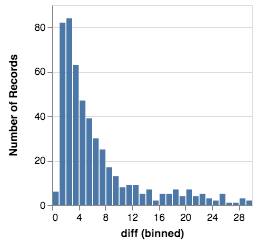

In [70]:
listener_assignments = json.load(open(cd('listener.assignments')))
speaker_assignments = json.load(open(cd('speaker.assignments')))
display(duration_plot(speaker_assignments))
display(duration_plot(listener_assignments))

In [71]:
import collections 

def by_worker(assign):
    workers = collections.defaultdict(int)
    for a in assign:
        workers[a['WorkerId']] += 1
    descending = sorted(workers.items(), key=lambda a: -a[1])
    return collections.OrderedDict(descending) 

listener_counts = by_worker(listener_assignments)
speaker_counts = by_worker(speaker_assignments)
intersection = set(speaker_counts.keys()).intersection(listener_counts.keys())

for k in intersection:
    print(k, listener_counts[k], speaker_counts[k])
print('speak: {} listener {} overlap {}'.format(len(speaker_counts), len(listener_counts), len(intersection)))

ACRA9J9JQKS05 1 4
AVBRJBJONL47I 4 1
A1AWHHBTJF1XCH 42 2
A2NA3O1SF7SQPF 4 11
A2IF4TYEH1MUKQ 6 5
A2N5A9UB883DT1 2 4
A2DWSKGD9RNKMJ 66 43
A1IU5OP7BBZHZ7 11 3
AZLZA0Q87TJZO 4 11
AISNLDPD2DFEG 4 3
AX6JQ37WUHFSH 10 6
speak: 60 listener 80 overlap 11


In [72]:
import pandas as pd
import collections
pd.set_option("display.max_rows", None)
dataf = open(cd('speaker.listener.jsonl'))
data = [json.loads(l) for l in dataf.readlines()]
utts = [l['q'][1]['utterance'] for l in data]
formulas = [l['q'][1]['targetFormula'] for l in data]
paths = list(map(lambda x: x[:x.index(':')], formulas))
pathsset = set(paths) 
pathcounter = collections.Counter(paths)
uniques = [k for k in pathcounter.keys() if pathcounter[k] <= 1]
freqfreq = pathcounter.values()
spec = {
      "data": {"values": [{"diff": v} for v in freqfreq]},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "diff",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
display(alt.VegaLite(spec))

print(len(paths), len(pathsset), len(uniques))
table = pd.DataFrame({'utterances': uniques})
display(table)


FileNotFoundError: [Errno 2] No such file or directory: 'hits/2018-08-29_22-54-16/speaker.listener.jsonl'